## Kaggle 泰坦尼克号幸存者预测

### 1.数据预处理

#### 数据预览

In [201]:
import pandas as pd
import numpy as np

# 数据加载
train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")
# 数据规模
print("train shape:", train.shape)
print("test shape:", test.shape)
# 数据预览
display(train.head(10))
# 数据信息
display(train.describe())

train shape: (891, 12)
test shape: (418, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


#### 数据清洗

In [202]:
def data_process(data):
    # 缺失的登船地点直接用众数填充
    data['Embarked'].fillna(data['Embarked'].mode()[0], inplace=True)
    # 统计年龄与其他数字项的相关程度
    # tmp = data[['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']]
    # display(tmp.corr()['Age'].sort_values())
    # 计算各个 Pclass 的年龄中位数
    display(data.groupby('Pclass')['Age'].median())
    # 用各个 Pclass 的年龄中位数填充
    data['Age'].fillna(data.groupby('Pclass')['Age'].transform('median'), inplace=True)
    # # 船舱号缺失值过多，只考虑有无船舱号
    data['Cabin'].fillna(0, inplace=True)
    data.loc[data['Cabin'] != 0, 'Cabin'] = 1
    # 直接删除
    # train.drop(['Cabin'], axis=1, inplace=True)
    # 姓名，只保留称谓
    data['Name'] = data['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
    # Ticket 是独一无二的，直接删除
    data.drop(['Ticket'], axis=1, inplace=True)
    return data

train = data_process(train)
display(train.isna().sum())
display(train.head(10))

Pclass
1    37.0
2    29.0
3    24.0
Name: Age, dtype: float64

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Cabin          0
Embarked       0
dtype: int64

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,1,0,3,Mr,male,22.0,1,0,7.2500,0,S
1,2,1,1,Mrs,female,38.0,1,0,71.2833,1,C
2,3,1,3,Miss,female,26.0,0,0,7.9250,0,S
3,4,1,1,Mrs,female,35.0,1,0,53.1000,1,S
4,5,0,3,Mr,male,35.0,0,0,8.0500,0,S
5,6,0,3,Mr,male,24.0,0,0,8.4583,0,Q
6,7,0,1,Mr,male,54.0,0,0,51.8625,1,S
7,8,0,3,Master,male,2.0,3,1,21.0750,0,S
8,9,1,3,Mrs,female,27.0,0,2,11.1333,0,S
9,10,1,2,Mrs,female,14.0,1,0,30.0708,0,C


#### 特征统计

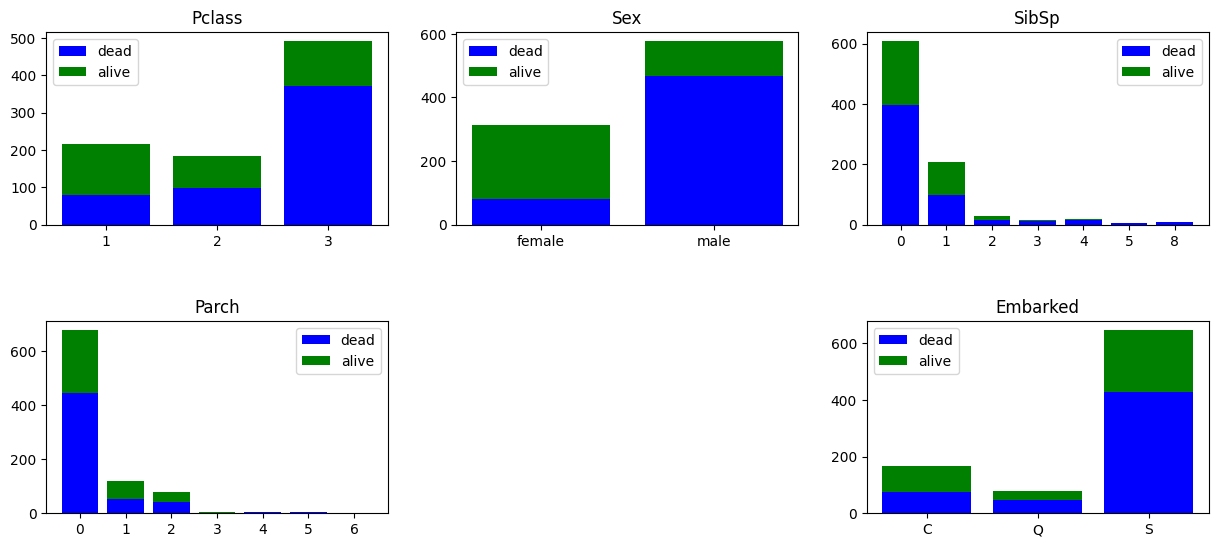

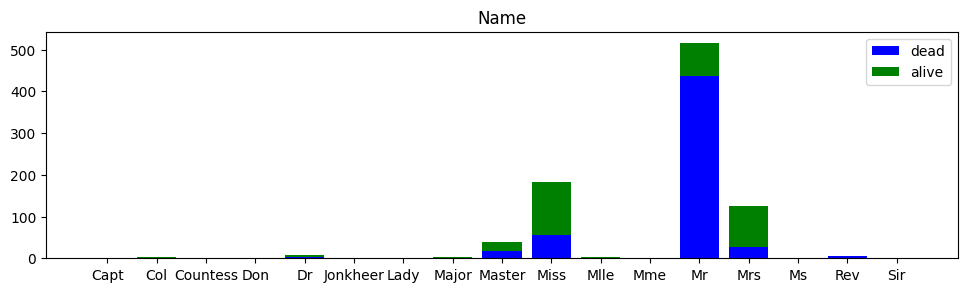

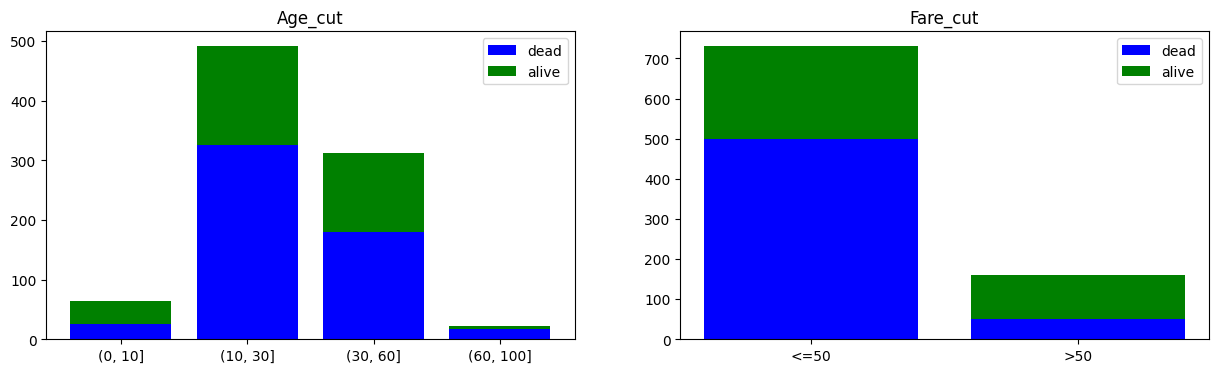

In [203]:
import matplotlib.pyplot as plt
# 画出特征与对应存活人数的堆叠柱状图
def plot_bar(feature, type=0):
    # 离散型特征
    if type == 0:
        # 横坐标为特征取值，可能是非数值型
        value = train[feature].unique()
        # 横坐标排序
        value.sort()
        y1 = []
        y2 = []
        for x_i in value:
            y1.append(train.loc[(train[feature] == x_i) & (train['Survived'] == 0)].shape[0])
            y2.append(train.loc[(train[feature] == x_i) & (train['Survived'] == 1)].shape[0])
        # 画图
        x = range(len(value))
        plt.bar(x, y1, color='b', label='dead')
        plt.bar(x, y2, bottom=y1, color='g', label='alive')
        # 设置横坐标刻度
        plt.xticks(x, value)
        plt.legend()
        plt.title(feature)

plt.figure(figsize=(15, 10))
# 增加上下间距
plt.subplots_adjust(hspace=0.5)
plt.subplot(3, 3, 1)
plot_bar('Pclass')
plt.subplot(3, 3, 2)
plot_bar('Sex')
plt.subplot(3, 3, 3)
plot_bar('SibSp')
plt.subplot(3, 3, 4)
plot_bar('Parch')
# plt.subplot(3, 3, 5)
# plot_bar('Cabin')
plt.subplot(3, 3, 6)
plot_bar('Embarked')
plt.figure(figsize=(40, 10))
plt.subplot(3, 3, 7)
plot_bar('Name')
plt.show()

# 年龄划分为四个区间：0~10为儿童；10~30为年轻人；30~60为中年人；60以上为老年人
# 新建一列 Age_cut，字符串类型
train['Age_cut'] = '(0, 10]'
# 将年龄划分为四个区间
train.loc[train['Age'] > 10, 'Age_cut'] = '(10, 30]'
train.loc[train['Age'] > 30, 'Age_cut'] = '(30, 60]'
train.loc[train['Age'] > 60, 'Age_cut'] = '(60, 100]'
# 画出年龄分布
plt.figure(figsize=(15, 10))
plt.subplots_adjust(hspace=0.5)
plt.subplot(2, 2, 1)
plot_bar('Age_cut')
# 票价每 50 为一个区间
train['Fare_cut'] = '<=50'
train.loc[train['Fare'] > 50, 'Fare_cut'] = '>50'
plt.subplot(2, 2, 2)
plot_bar('Fare_cut')
plt.show()
train.drop(['Age_cut', 'Fare_cut'], axis=1, inplace=True)

### 2.模型构建

#### 特征工程

In [204]:
import sklearn.preprocessing as preprocessing
# 特征因子化, one-hot 编码
def set_numeralization(data):
    # 针对定类性属性进行因子化，分别有Embarked,Sex,Pclass
    dummies_Embarked = pd.get_dummies(data['Embarked'], prefix='Embarked')
    dummies_Sex = pd.get_dummies(data['Sex'], prefix='Sex')
    dummies_Pclass = pd.get_dummies(data['Pclass'], prefix='Pclass')
    # 将 Name 转为数值型，保留人数大于 10 的称谓
    name = data['Name'].value_counts()
    name = name[name > 10].index
    data.loc[~data['Name'].isin(name), 'Name'] = 0
    dummies_Name = pd.get_dummies(data['Name'], prefix='Name')

    # 将新的属性拼合
    df = pd.concat([data, dummies_Name, dummies_Embarked, dummies_Sex, dummies_Pclass], axis=1)
    # 将旧的属性剔除
    df.drop(['Name', 'Pclass', 'Sex', 'Embarked'], axis=1, inplace=True)
    return df

# 特征归一化
def set_normalization(df):
    scaler = preprocessing.StandardScaler()
    age_scale_param = scaler.fit(df['Age'].values.reshape(-1,1))
    df['Age_scaled'] = scaler.fit_transform(df['Age'].values.reshape(-1,1),age_scale_param)
    fare_scale_param = scaler.fit(df['Fare'].values.reshape(-1,1))
    df['Fare_scaled'] = scaler.fit_transform(df['Fare'].values.reshape(-1,1),fare_scale_param)
    df.drop(['Age', 'Fare'], axis=1, inplace=True)
    return df

# 特征工程
train = set_numeralization(train)
train = set_normalization(train)
display(train.head(10))
# 选取特征
x_train = train.drop(['PassengerId', 'Survived'], axis=1)
# 标签
y_train = train['Survived']

# 测试集
# 读取测试集
test = pd.read_csv("../data/test.csv")
# 数据预处理
test = data_process(test)
# 有个坑，测试集中 Fare 有一个缺失值，用对应 Pclass 的中位数填充
test['Fare'].fillna(test.groupby('Pclass')['Fare'].transform('median'), inplace=True)
# 特征工程
test = set_numeralization(test)
test = set_normalization(test)
display(test.head(10))
x_test = test.drop(['PassengerId'], axis=1)

,PassengerId,Survived,SibSp,Parch,Cabin,Name_0,Name_Master,Name_Miss,Name_Mr,Name_Mrs,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Age_scaled,Fare_scaled
0,1,0,1,0,0,False,False,False,True,False,False,False,True,False,True,False,False,True,-0.533834,-0.502445
1,2,1,1,0,1,False,False,False,False,True,True,False,False,True,False,True,False,False,0.674891,0.786845
2,3,1,0,0,0,False,False,True,False,False,False,False,True,True,False,False,False,True,-0.231653,-0.488854
3,4,1,1,0,1,False,False,False,False,True,False,False,True,True,False,True,False,False,0.448255,0.420730
4,5,0,0,0,0,False,False,False,True,False,False,False,True,False,True,False,False,True,0.448255,-0.486337
5,6,0,0,0,0,False,False,False,True,False,False,True,False,False,True,False,False,True,-0.382743,-0.478116
6,7,0,0,0,1,False,False,False,True,False,False,False,True,False,True,True,False,False,1.883615,0.395814
7,8,0,3,1,0,False,True,False,False,False,False,False,True,False,True,False,False,True,-2.044739,-0.224083
8,9,1,0,2,0,False,False,False,False,True,False,False,True,True,False,False,False,True,-0.156107,-0.424256
9,10,1,1,0,0,False,False,False,False,True,True,False,False,True,False,False,True,False,-1.138196,-0.042956


Pclass
1    42.0
2    26.5
3    24.0
Name: Age, dtype: float64

,PassengerId,SibSp,Parch,Cabin,Name_0,Name_Master,Name_Miss,Name_Mr,Name_Mrs,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Age_scaled,Fare_scaled
0,892,0,0,0,False,False,False,True,False,False,True,False,False,True,False,False,True,0.393048,-0.497071
1,893,1,0,0,False,False,False,False,True,False,False,True,True,False,False,False,True,1.356309,-0.511934
2,894,0,0,0,False,False,False,True,False,False,True,False,False,True,False,True,False,2.512223,-0.463762
3,895,0,0,0,False,False,False,True,False,False,False,True,False,True,False,False,True,-0.184909,-0.482135
4,896,1,1,0,False,False,False,False,True,False,False,True,True,False,False,False,True,-0.570214,-0.417159
5,897,0,0,0,False,False,False,True,False,False,False,True,False,True,False,False,True,-1.186701,-0.472052
6,898,0,0,0,False,False,True,False,False,False,True,False,True,False,False,False,True,0.046273,-0.500656
7,899,1,1,0,False,False,False,True,False,False,False,True,False,True,False,True,False,-0.261970,-0.117599
8,900,0,0,0,False,False,False,False,True,True,False,False,True,False,False,False,True,-0.878458,-0.507826
9,901,2,0,0,False,False,False,True,False,False,False,True,False,True,False,False,True,-0.647275,-0.204532


#### 训练模型

##### 逻辑回归

In [205]:
# 逻辑回归模型，训练集为 train，标签为 Survived
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
# 训练
lr.fit(x_train, y_train)
# 预测
# display(x_train.head(10))
y_pred = lr.predict(x_train)
# 准确率
print("Accuracy:", lr.score(x_train, y_train))
# 预测
y_test = lr.predict(x_test)
# 保存结果
result = pd.DataFrame({'PassengerId': test['PassengerId'], 'Survived': y_test})
result.to_csv("../result/lr_predict.csv", index=False)

Accuracy: 0.8406285072951739


##### SVM 支持向量机

In [206]:
# SVM 模型
from sklearn.svm import SVC
svc = SVC(probability=True)
svc.fit(x_train, y_train)
y_pred = svc.predict(x_train)
print("Accuracy:", svc.score(x_train, y_train))
y_test = svc.predict(x_test)
result = pd.DataFrame({'PassengerId': test['PassengerId'], 'Survived': y_test})
result.to_csv("../result/svm_predict.csv", index=False)

Accuracy: 0.8484848484848485


##### K最近邻算法

In [207]:
# K 最近邻模型
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(x_train, y_train)
y_pred = knn.predict(x_train)
print("Accuracy:", knn.score(x_train, y_train))
y_test = knn.predict(x_test)
result = pd.DataFrame({'PassengerId': test['PassengerId'], 'Survived': y_test})
result.to_csv("../result/knn_predict.csv", index=False)

Accuracy: 0.8630751964085297


##### 决策树

In [208]:
# 决策树模型
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(x_train, y_train)
y_pred = dt.predict(x_train)
print("Accuracy:", dt.score(x_train, y_train))
y_test = dt.predict(x_test)
# result = pd.DataFrame({'PassengerId': test['PassengerId'], 'Survived': y_test})
# result.to_csv("../result/dt_predict.csv", index=False)
# 明显过拟合!!!

# 调参 max_depth, min_samples_split, min_samples_leaf
from sklearn.model_selection import GridSearchCV
param_grid = {'max_depth': np.arange(1, 10), 'min_samples_split': np.arange(2, 10), 'min_samples_leaf': np.arange(1, 10)}
grid = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5)
grid.fit(x_train, y_train)
print(grid.best_params_)
dt_best = grid.best_estimator_
y_pred = dt_best.predict(x_train)
print("Accuracy:", dt_best.score(x_train, y_train))
y_test = dt_best.predict(x_test)
result = pd.DataFrame({'PassengerId': test['PassengerId'], 'Survived': y_test})
result.to_csv("../result/dt_best_predict.csv", index=False)

Accuracy: 0.9876543209876543
{'max_depth': 4, 'min_samples_leaf': 9, 'min_samples_split': 2}
Accuracy: 0.8484848484848485


##### 随机森林

In [209]:
# 随机森林模型
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(x_train, y_train)
y_pred = rf.predict(x_train)
print("Accuracy:", rf.score(x_train, y_train))
y_test = rf.predict(x_test)
# result = pd.DataFrame({'PassengerId': test['PassengerId'], 'Survived': y_test})
# result.to_csv("../result/rf_predict.csv", index=False)
# 明显过拟合

# 调参 n_estimators, max_depth, min_samples_split, min_samples_leaf
# 使用 RandomizedSearchCV, 速度更快
from sklearn.model_selection import RandomizedSearchCV
param_grid = {'n_estimators': np.arange(10, 100), 'max_depth': np.arange(1, 10), 'min_samples_split': np.arange(2, 10), 'min_samples_leaf': np.arange(1, 10)}
grid = RandomizedSearchCV(RandomForestClassifier(), param_grid, cv=5)
grid.fit(x_train, y_train)
print(grid.best_params_)
rf_best = grid.best_estimator_
y_pred = rf_best.predict(x_train)
print("Accuracy:", rf_best.score(x_train, y_train))
y_test = rf_best.predict(x_test)
result = pd.DataFrame({'PassengerId': test['PassengerId'], 'Survived': y_test})
result.to_csv("../result/rf_best_predict.csv", index=False)
# 记一下最好的参数
# {'n_estimators': 46, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_depth': 7}


Accuracy: 0.9876543209876543
{'n_estimators': 59, 'min_samples_split': 9, 'min_samples_leaf': 4, 'max_depth': 8}
Accuracy: 0.8664421997755332


#### 模型融合

In [210]:
# 选择效果比较好的模型，进行集成学习
# 使用 VotingClassifier
from sklearn.ensemble import VotingClassifier
voting = VotingClassifier(estimators=[('lr', lr), ('svc', svc), ('knn', knn), ('dt', dt_best), ('rf', rf_best)], voting='soft')
voting.fit(x_train, y_train)
y_pred = voting.predict(x_train)
print("Accuracy:", voting.score(x_train, y_train))
y_test = voting.predict(x_test)
result = pd.DataFrame({'PassengerId': test['PassengerId'], 'Survived': y_test})
result.to_csv("../result/voting_predict.csv", index=False)

Accuracy: 0.8529741863075196


### 3.模型评估

#### 交叉验证

In [211]:
# 交叉验证评估模型
from sklearn.model_selection import cross_val_score
# 逻辑回归
lr_cv = cross_val_score(lr, x_train, y_train, cv=5)
print("lr_cv:", lr_cv.mean())
# SVM
svc_cv = cross_val_score(svc, x_train, y_train, cv=5)
print("svc_cv:", svc_cv.mean())
# KNN
knn_cv = cross_val_score(knn, x_train, y_train, cv=5)
print("knn_cv:", knn_cv.mean())
# 决策树
dt_cv = cross_val_score(dt_best, x_train, y_train, cv=5)
print("dt_cv:", dt_cv.mean())
# 随机森林
rf_cv = cross_val_score(rf_best, x_train, y_train, cv=5)
print("rf_cv:", rf_cv.mean())
# 融合模型
voting_cv = cross_val_score(voting, x_train, y_train, cv=5)
print("voting_cv:", voting_cv.mean())

lr_cv: 0.8293892411022534
svc_cv: 0.8327600276191074
knn_cv: 0.8047140794677045
dt_cv: 0.8293829640323898
rf_cv: 0.8271608813006088
voting_cv: 0.8293892411022534


#### 混淆矩阵

In [212]:
# 输出准确率、召回率、F1 值的表格
from sklearn.metrics import confusion_matrix
# 逻辑回归
lr_cm = confusion_matrix(y_train, lr.predict(x_train))
lr_precision = lr_cm[1, 1] / (lr_cm[0, 1] + lr_cm[1, 1])
lr_recall = lr_cm[1, 1] / (lr_cm[1, 0] + lr_cm[1, 1])
lr_f1 = 2 * lr_precision * lr_recall / (lr_precision + lr_recall)
# SVM
svc_cm = confusion_matrix(y_train, svc.predict(x_train))
svc_precision = svc_cm[1, 1] / (svc_cm[0, 1] + svc_cm[1, 1])
svc_recall = svc_cm[1, 1] / (svc_cm[1, 0] + svc_cm[1, 1])
svc_f1 = 2 * svc_precision * svc_recall / (svc_precision + svc_recall)
# KNN
knn_cm = confusion_matrix(y_train, knn.predict(x_train))
knn_precision = knn_cm[1, 1] / (knn_cm[0, 1] + knn_cm[1, 1])
knn_recall = knn_cm[1, 1] / (knn_cm[1, 0] + knn_cm[1, 1])
knn_f1 = 2 * knn_precision * knn_recall / (knn_precision + knn_recall)
# 决策树
dt_cm = confusion_matrix(y_train, dt_best.predict(x_train))
dt_precision = dt_cm[1, 1] / (dt_cm[0, 1] + dt_cm[1, 1])
dt_recall = dt_cm[1, 1] / (dt_cm[1, 0] + dt_cm[1, 1])
dt_f1 = 2 * dt_precision * dt_recall / (dt_precision + dt_recall)
# 随机森林
rf_cm = confusion_matrix(y_train, rf_best.predict(x_train))
rf_precision = rf_cm[1, 1] / (rf_cm[0, 1] + rf_cm[1, 1])
rf_recall = rf_cm[1, 1] / (rf_cm[1, 0] + rf_cm[1, 1])
rf_f1 = 2 * rf_precision * rf_recall / (rf_precision + rf_recall)
# 融合模型
voting_cm = confusion_matrix(y_train, voting.predict(x_train))
voting_precision = voting_cm[1, 1] / (voting_cm[0, 1] + voting_cm[1, 1])
voting_recall = voting_cm[1, 1] / (voting_cm[1, 0] + voting_cm[1, 1])
voting_f1 = 2 * voting_precision * voting_recall / (voting_precision + voting_recall)
# 表格形式输出
df = pd.DataFrame({'precision': [lr_precision, svc_precision, knn_precision, dt_precision, rf_precision, voting_precision],
                   'recall': [lr_recall, svc_recall, knn_recall, dt_recall, rf_recall, voting_recall],
                   'f1': [lr_f1, svc_f1, knn_f1, dt_f1, rf_f1, voting_f1]},
                  index=['lr', 'svc', 'knn', 'dt', 'rf', 'voting'])
display(df)

,precision,recall,f1
lr,0.810559,0.763158,0.786145
svc,0.843854,0.742690,0.790047
knn,0.843750,0.789474,0.815710
dt,0.834951,0.754386,0.792627
rf,0.883162,0.751462,0.812006
voting,0.860068,0.736842,0.793701


#### ROC曲线

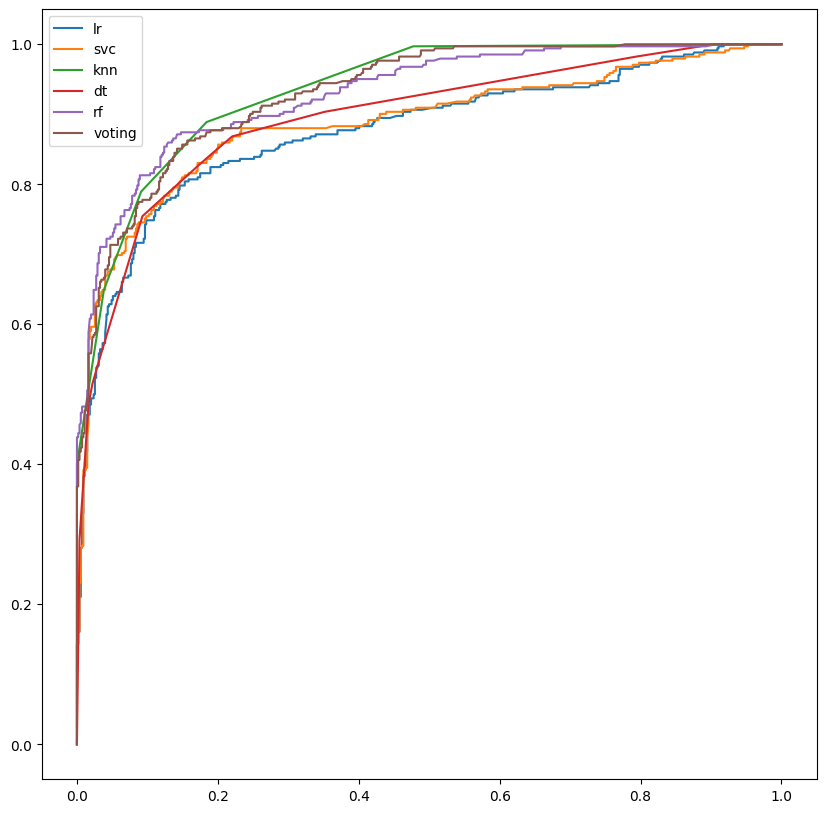

In [213]:
from sklearn.metrics import roc_curve
# 逻辑回归
lr_fpr, lr_tpr, lr_thresholds = roc_curve(y_train, lr.predict_proba(x_train)[:, 1])
# SVM
svc_fpr, svc_tpr, svc_thresholds = roc_curve(y_train, svc.decision_function(x_train))
# KNN
knn_fpr, knn_tpr, knn_thresholds = roc_curve(y_train, knn.predict_proba(x_train)[:, 1])
# 决策树
dt_fpr, dt_tpr, dt_thresholds = roc_curve(y_train, dt_best.predict_proba(x_train)[:, 1])
# 随机森林
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_train, rf_best.predict_proba(x_train)[:, 1])
# 融合模型，硬投票
voting_fpr, voting_tpr, voting_thresholds = roc_curve(y_train, voting.predict_proba(x_train)[:, 1])

# 画出 ROC 曲线
plt.figure(figsize=(10, 10))
plt.plot(lr_fpr, lr_tpr, label='lr')
plt.plot(svc_fpr, svc_tpr, label='svc')
plt.plot(knn_fpr, knn_tpr, label='knn')
plt.plot(dt_fpr, dt_tpr, label='dt')
plt.plot(rf_fpr, rf_tpr, label='rf')
plt.plot(voting_fpr, voting_tpr, label='voting')
plt.legend()
plt.show()